<a href="https://colab.research.google.com/github/amanbhal/data-science/blob/master/NYE_Stock_Exchange_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Import all required libraries

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.core import Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

import time

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)

### Load the dataset and filter the dataset for the stock for which you want to perform the analysis. Drop the unwanted features present in the data.

In [0]:
# load dataset
df = pd.read_csv("/content/drive/My Drive/ColabDatasets/NY_Stock_Market/prices-split-adjusted.csv")

# select one company for data analysis
df = df[df['symbol']=='WMT']

# drop unwanted columns
df = df.drop(['date', 'symbol'], axis=1)

### Define all the variables needed for temporalizing the data.
In the 3D array, X, each 2D block at X[i,:,:] denotes the prediction data that corresponds to y[i] . To draw an analogy, in regression y[i] corresponds to a 1D vector X[i,:] ; in LSTM y[i] corresponds to a 2D array X[i,:,:] .
This 2D block X[i,:,:] should have the predictors at input_X[i,:] and the previous rows up to the given lookback .
This is done by ***temporalize*** function defined below.

In [0]:
# lookback x days in past
lookback = 1
n_features = df.shape[1]
feature_set_for_y = [0]
number_of_outputs = len(feature_set_for_y)

def temporalize(X, lookback):
    output_X = []
    output_Y = []
    for i in range(len(X)-lookback-1):
        temp = X[i:(i+lookback), :]
        output_X.append(temp)
        # predicting lookback days ahead
        output_Y.append(X[i+lookback, feature_set_for_y])
    return np.array(output_X), np.array(output_Y)

In [0]:
X, y = temporalize(np.array(df), lookback)

### Split the data into test and train.
We did not use the ***train_test_split*** function because it randomly splits the data into train and test. As we want to preserve the order of data therefore we will split the consecutive rows.

In [0]:
# split data into test and train
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(df),:]
y_train, y_test = y[0:train_size,:], y[train_size:len(df),:]

# reshape train and test for LSTM model
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)

### Feature Scaling
Since ***X_train*** is a 3D metrics therefore to scale it we have defined two functions: ***flatten*** and ***scale***.

***flatten*** : This function will re-create the original 2D array from which the 3D arrays were created. This function is the inverse of temporalize, meaning X = flatten(temporalize(X)).

***scale*** : This function will scale a 3D array that we created as inputs to the LSTM.

We have to use seperate scaler ojects for both X and y as both have different dimensions

*NOTE: One common standardization mistake is: we normalize the entire data and then split into train-test. This is incorrect. Test data should be completely unseen to anything during the modeling. We should, therefore, normalize the training data, and use its summary statistics to normalize the test data (for normalization, these statistics are the mean and variances of each feature).*

In [0]:
# feature scaling for the data
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X
  
# Initialize a scaler using the training data.
X_scaler = MinMaxScaler(feature_range=(0, 1)).fit(flatten(X_train))
X_train_scaled = scale(X_train, X_scaler)
X_test_scaled = scale(X_test, X_scaler)

y_scaler = MinMaxScaler(feature_range=(0, 1)).fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### Generating the model

In [0]:
# build the LSTM model

model = Sequential()

model.add(LSTM(
    input_shape=(lookback, n_features),
    return_sequences=True,
    units=50))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=number_of_outputs))
model.add(Activation('relu'))

start = time.time()
model.compile(loss='mse', optimizer='adam')

### Run model on training and validation data

In [68]:
model.fit(X_train_scaled, y_train_scaled, batch_size=128, epochs=20, validation_split=0.05)

Train on 1338 samples, validate on 71 samples
Epoch 1/20
1338/1338 [==============================] - 4s 3ms/step - loss: 0.2264 - val_loss: 0.2754
Epoch 2/20
1338/1338 [==============================] - 0s 80us/step - loss: 0.1523 - val_loss: 0.1478
Epoch 3/20
1338/1338 [==============================] - 0s 75us/step - loss: 0.0655 - val_loss: 0.0246
Epoch 4/20
1338/1338 [==============================] - 0s 75us/step - loss: 0.0190 - val_loss: 0.0033
Epoch 5/20
1338/1338 [==============================] - 0s 76us/step - loss: 0.0183 - val_loss: 3.0741e-04
Epoch 6/20
1338/1338 [==============================] - 0s 85us/step - loss: 0.0112 - val_loss: 0.0037
Epoch 7/20
1338/1338 [==============================] - 0s 72us/step - loss: 0.0092 - val_loss: 5.7866e-04
Epoch 8/20
1338/1338 [==============================] - 0s 87us/step - loss: 0.0068 - val_loss: 1.4597e-04
Epoch 9/20
1338/1338 [==============================] - 0s 74us/step - loss: 0.0046 - val_loss: 6.1813e-04
Epoch 10/20


### Predict and Plot

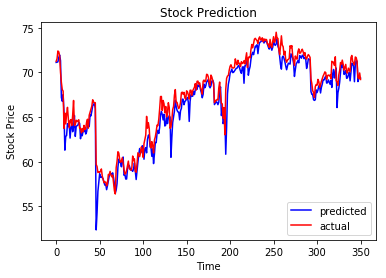

In [69]:
y_pred = model.predict(X_test_scaled)

plt.plot(y_scaler.inverse_transform(y_pred), 'b', label='predicted')
plt.plot(y_scaler.inverse_transform(y_test_scaled), 'r', label='actual')
plt.title('Stock Prediction')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend(loc='lower right')
plt.show()
